In [1]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D ##library for 3d projection plots
%matplotlib inline

# High-Level Waste : Technology

Having covered the policy related to high level waste, we will now discuss the technology.

## Learning Objectives

At the end of this lesson, you will be equipped to:

- Recognize the relationship between decay and repository heat burden.
- Calculate the decay heat of UNF as a function of reactor power and time since discharge.
- Calculate radiotoxicity of a mixture of isotopes over time.
- Explain the characteristics and purpose of _the reference man_.
- Recognize the barriers between a disposed waste form and the reference man.
- List mechanisms involved in radionuclide contaminant transport.
- Estimate the radionuclide transport impacts of solubility, sorption, retardation, diffusion, and advection.
- Differentiate between reducing and oxidizing geologic host media. 


## Radioactivity

Recall: The SI unit of activity is the becquerel (Bq), equal to one reciprocal second.

\begin{align}
A(i) &= -\frac{dN_i}{dt}\\
&= \lambda_iN_i
\end{align}

And, given these decays, we also know that 

\begin{align}
N(t) = N_0e^{t/\tau}
\end{align}

## Decay Heat

How do we get from radiation to heat?

![https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Question_Mark.svg/2000px-Question_Mark.svg.png](https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Question_Mark.svg/2000px-Question_Mark.svg.png)


\begin{align}
f(t) &= \sum_i\left( \bar{E}_{\beta,i} + \bar{E}_{\gamma, i} + \bar{E}_{\alpha, i}\right)A(i)\\
     &= \sum_i\left( \bar{E}_{\beta,i} + \bar{E}_{\gamma, i} + \bar{E}_{\alpha, i}\right)\lambda_iN_i(t)\\
\end{align}


Recall that we know how to get the populations $N_i$ of all isotopes built up in the reactor. 




/Users/khuff/anaconda/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/Users/khuff/anaconda/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)


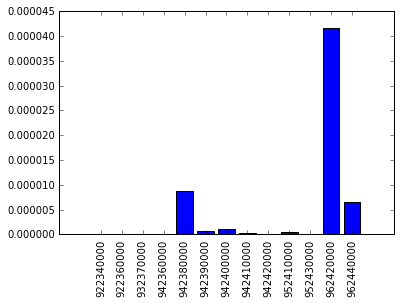

In [2]:
from pyne import data

data.decay_const('u238')
 
from pyne.material import Material
lwr_snf_ma = Material({'U234': 0.12, 
                    'U236': 4.18,
                    'Np237': 0.75,
                    '236Pu': 9.2E-6,
                    '238Pu': 0.22,
                    '239Pu': 5.28,
                    '240Pu': 2.17,
                    '241Pu': 1.02,
                    '242Pu': 0.35,
                    '241Am': 0.05,
                    '243Am': 0.09,
                    '242Cm': 4.9E-3,
                    '244Cm': 3.3E-2},
                   1000)

#print(lwr_snf_ma.comp)
#print(lwr_snf_ma.activity())
#print(lwr_snf_ma.decay_heat())
D=lwr_snf_ma.decay_heat()

import matplotlib.pylab as plt
plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys(), rotation='vertical')

plt.show()

## Decay Heat and Geologic Heat Capacity

![concept_features.png](./concept_features.png)



## Toxicity

One possibility is to use toxicity as a classifying metric. It captures the 

\begin{align}
\mbox{Toxicity}(i,k) &= \frac{A(i)}{DAC(i,k)}\\
i &= \mbox{isotope}\\
k &= \mbox{medium index, air or water}\\
DAC &= \mbox{derived air concentration of isotope i in air or water.} 
\end{align}


### Example: Toxicity

Which is more dangerous, 7.2mg of $^{90}Sr$ or 0.8g of $^{239}Pu$? 


In [3]:

def tox(activity, dac):
    """returns the radiotoxicity of a sample
    :param activity: activity of the sample in Bq
    :param dac: derived air concentration for the active isotope in the sample
    """
    return activity/dac

To solve this, we'll need to go look up the DAC for each isotope. 

\begin{align}
DAC_{^{90}Sr} &= 8\times 10^{-9}\left[\frac{\mu Ci}{cm^3}\right]\\
DAC_{^{239}Pu} &= 3\times 10^{-12}\left[\frac{\mu Ci}{cm^3}\right]\\
\end{align}

In [4]:
dac_90_sr = 8E-9
dac_239_pu = 3E-12

And, we'll need to calculate the activity of the sample. First, we'll need the number of atoms as a function of the mass of each isotope.

\begin{align}
N_i &= N_A\frac{m_i}{A}\\
N_i &= \mbox{number of atoms in the sample}\\
N_A &= \mbox{Avogadro's number, atoms per mol}\\
m_i &= \mbox{mass of isotope i in the sample}\\
A &= \mbox{Atomic mass}
\end{align}


![https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Question_Mark.svg/2000px-Question_Mark.svg.png](https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Question_Mark.svg/2000px-Question_Mark.svg.png)

In [5]:
def n_from_mass(iso, g):
    from pyne import data
    from scipy import constants as sc
    a = data.atomic_mass(iso)
    avo = sc.Avogadro
    return (g/a)*avo

In [6]:
## Test it
n_from_mass('1H', 1)

5.9753832901678335e+23

In [7]:
def activity(iso, n):
    """returns the activity of some N atoms of an isotope
    :param iso: the isotope
    :param n: number of atoms in the sample 
    """
    from pyne import data
    lam = data.decay_const(iso)
    return n*lam

**BUT: All of this has been done in Bq. Recall that our toxicity calculation needs Ci. Let's report our activities in Ci.'**

In [8]:
def bq_to_ci(bq):
    return bq/3.7E10

sr_activity =  bq_to_ci(activity('Sr90', 
                                 (n_from_mass('Sr90', 
                                              0.8))))
pu_activity = bq_to_ci(activity('Pu239', 
                                (n_from_mass('Pu239', 
                                             0.8))))
                        
print("90Sr activity [Ci] = ", sr_activity)
print("239Pu activity [Ci] = ", pu_activity)

90Sr activity [Ci] =  110.48974430129589
239Pu activity [Ci] =  0.04962160155426739


In [9]:
print("90Sr toxicity = ", '%e' % tox(sr_activity, dac_90_sr), "\n"
"239Pu toxicity = ", '%e' % tox(pu_activity, dac_239_pu))

90Sr toxicity =  1.381122e+10 
239Pu toxicity =  1.654053e+10


In [24]:
dac_99_tc = 3E-7
dac_137_cs = 6E-8

tc_activity =  bq_to_ci(activity('Tc99', 
                                 (n_from_mass('Tc99', 
                                              1))))
cs_activity = bq_to_ci(activity('Cs137', 
                                (n_from_mass('Cs137', 
                                             0.001))))
                        
print("99Tc activity [Ci] = ", tc_activity)
print("137Cs activity [Ci] = ", cs_activity)
print("99Tc toxicity = ", '%e' % tox(tc_activity, dac_99_tc), "\n"
"137Cs toxicity = ", '%e' % tox(cs_activity, dac_137_cs))

99Tc activity [Ci] =  0.017122166117922367
137Cs activity [Ci] =  0.08680943113648998
99Tc toxicity =  5.707389e+04 
137Cs toxicity =  1.446824e+06


### Question: Units?

What were the units of toxicity, and how should we interperet those units?

![https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Question_Mark.svg/2000px-Question_Mark.svg.png](https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Question_Mark.svg/2000px-Question_Mark.svg.png)


## Empirical Activity Fits


An aside... note that your book gives the following empirical equation for post-reactor burnup activity. 

\begin{align}
R(t) &=
\begin{cases}
 A_1e^{\left(\frac{1}{A_2 + A_3t}\right)} & t<30y\\
 B_1t^{-a}\left[1+ \frac{B_2}{1+\left(\frac{t}{B_3}\right)^4}\right] & 30<t<1\times10^5y\\
 \end{cases}\\
\end{align}
For a 1250 Mwe PWR with $\eta=0.33$, average specific power of 37.5 MWth/tHM, and 33,000 MWd/tHM burnup, the coefficients are:

\begin{align}
A_1 &= 1.42\times10^5\\
 A_2 &= 0.296\\
 A_3 &= 7.22\times10^{-2}\\
 a &= 0.2680\\
 B_1 &= 1.98\times10^5\\
 B_2 &= 10\\
 B_3 &= 88\\
\end{align}

## Release

**Source Term** Radionuclide mass flux to the environment
- Safety and Risk Metric
- EPA Regulation


**Radionuclide transport** is a function of
- Geochemistry 
  - chemically induced material degradation
  - radionuclide solubility limits
  - sorption
  - colloid mobility, etc.
- Hydrology 
  - water induced material degradation, 
  - water movement (diffusion and advection) through pores and fractures, 
  - dissolved contaminant dispersion.
- Thermal Effects 
  - thermally induced material degradation, 
  - thermal hydrological effects.

![barriers.png](./barriers.png)

## Diffusion
[Diffusion code below from 12 steps to Navier Stokes, Lorena Barba.](http://nbviewer.jupyter.org/github/barbagroup/CFDPython/blob/master/lessons/09_Step_7.ipynb)

We begin with the 2D-diffusion equation:

$$\frac{\partial u}{\partial t} = \nu \frac{\partial ^2 u}{\partial x^2} + \nu \frac{\partial ^2 u}{\partial y^2}$$

Without going into details, just note that it is possible to discretize second order derivatives. The following scheme uses a _forward difference_ in time and two second-order derivatives. 

$$\frac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} = \nu \frac{u_{i+1,j}^n - 2 u_{i,j}^n + u_{i-1,j}^n}{\Delta x^2} + \nu \frac{u_{i,j+1}^n-2 u_{i,j}^n + u_{i,j-1}^n}{\Delta y^2}$$

This method requires that you reorganize the discretized equation and solve for $u_{i,j}^{n+1}$
\begin{align}
u_{i,j}^{n+1} = u_{i,j}^n &+ \frac{\nu \Delta t}{\Delta x^2}(u_{i+1,j}^n - 2 u_{i,j}^n + u_{i-1,j}^n) \\
&+ \frac{\nu \Delta t}{\Delta y^2}(u_{i,j+1}^n-2 u_{i,j}^n + u_{i,j-1}^n)
\end{align}

In [ ]:
### variable declarations
nx = 31
ny = 31
nt = 17
nu = 0.05
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .25
dt = sigma * dx * dy / nu

x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)

u = numpy.ones((ny, nx))  # create a 1xn vector of 1's
un = numpy.ones((ny, nx))

### Assign initial conditions
# set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2  

fig = pyplot.figure()
ax = fig.gca(projection='3d')
X, Y = numpy.meshgrid(x, y)
surf = ax.plot_surface(X, Y, u, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_zlim(1, 2.5)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

\begin{align}
u_{i,j}^{n+1} = u_{i,j}^n &+ \frac{\nu \Delta t}{\Delta x^2}(u_{i+1,j}^n - 2 u_{i,j}^n + u_{i-1,j}^n) \\
&+ \frac{\nu \Delta t}{\Delta y^2}(u_{i,j+1}^n-2 u_{i,j}^n + u_{i,j-1}^n)
\end{align}

In [ ]:
###Run through nt timesteps
def diffuse(nt):
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2  
    
    for n in range(nt + 1): 
        un = u.copy()
        u[1:-1, 1:-1] = (un[1:-1,1:-1] + 
                        nu * dt / dx**2 * 
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                        nu * dt / dy**2 * 
                        (un[2:,1: -1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1]))
        u[0, :] = 1
        u[-1, :] = 1
        u[:, 0] = 1
        u[:, -1] = 1

    
    fig = pyplot.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, u[:], rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=True)
    ax.set_zlim(1, 2.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$');
    

In [ ]:
diffuse(0)

In [ ]:
diffuse(50)

![./wf_release.png](./wf_release.png)
[6] J. A. Blink, T. A. Buscheck, W. G. Halsey, and T. Wolery.
Disposal systems evaluations and tool Development-Engineered barrier system evaluation
work package LL1015080425.
Technical report, Lawrence Livermore National Laboratory (LLNL), Livermore, CA, 2010.

## Hydrology 101: Adevection Dispersion Equation

 In a saturated, reducing environment, contaminants are transported by 
**diffusion**, **dispersion,** and **advection**. 
    
\begin{align}
      J &= J_{dis} + J_{adv}\nonumber\\
      &= -\theta(D_{mdis} + \tau D_m)\nabla C + \theta vC\nonumber\\ 
      &= -\theta D\nabla C + \theta vC \nonumber\\ 
      J_{dis} &= \mbox{ Total Dispersive Mass Flux }[kg/m^2/s]\nonumber\\
      J_{adv} &= \mbox{ Advective Mass Flux }[kg/m^2/s]\nonumber\\
      \tau &= \mbox{ Toruosity }[-] \nonumber\\
      \theta &= \mbox{ Porosity }[-] \nonumber\\
      D_m &= \mbox{ Molecular diffusion coefficient }[m^2/s]\nonumber\\
      D_{mdis} &= \mbox{ Coefficient of mechanical dispersivity}[m^2/s]\nonumber\\
      D &= \mbox{ Effective Dispersion Coefficient }[m^2/s]\nonumber\\
      C &= \mbox{ Concentration }[kg/m^3]\nonumber\\
      v &= \mbox{ Fluid Velocity in the medium }[m/s].\nonumber
\end{align}


(From F. W. Schwartz and H. Zhang. Fundamentals of ground water. Environmental Geology, 45:10371038, 2004.)

One can express this slightly more simply as: 

\begin{align} 
  \frac{\partial n C}{\partial t} & = - \nabla \cdot  (F_c + F_{dc} + F_d) + m 
\end{align}

\begin{align}
      n &= \mbox{solute accessible porosity } [\%]\nonumber\\
      C &= \mbox{ concentration } [kg \cdot m^{-3}]\nonumber\\ 
      t &= \mbox{ time } [s]\nonumber\\ 
      F_c &= \mbox{ advective transport} [kg \cdot m^{-2}\cdot s^{-1}]\nonumber\\
      &= nvC \nonumber \\
      F_{dc} &= \mbox{ dispersive transport} [kg \cdot m^{-2}\cdot s^{-1}]\nonumber\\ 
      &= \alpha nv \nabla C  \nonumber\\ 
      F_d &= \mbox{ diffusive transport} [kg \cdot m^{-2}\cdot s^{-1}]\nonumber\\
      &= D_e \nabla C\nonumber
    \end{align}
    \begin{align}
      m &= \mbox{ solute source } [kg \cdot m^{-3}\cdot s^{-1}].\nonumber\\
      v &= \mbox{ pore velocity } [m\cdot s^{-1}] \nonumber\\
      \alpha &= \mbox{ dispersivity } [m]\nonumber\\
      D_e &= \mbox{ effective diffusion coefficient } [m^2\cdot s^{-1}]\nonumber\\
      n\cdot v &= \mbox{ Darcy velocity } [m\cdot s^{-1}].
    \end{align} 




## Dispersion

Dispersion captures the impact of the tortuous path fluids must take through porous media:

![https://www.nap.edu/openbook/0309049946/xhtml/images/img00014.gif](https://www.nap.edu/openbook/0309049946/xhtml/images/img00014.gif)

It is customary to define the combination of molecular diffusion, $D_e$ and mechanical dispersion, $\alpha v$, as $D$ 
\begin{align}
  D = \alpha v + D_e
\end{align}
such that the mass conservation equation becomes:

\begin{align}
  D = \alpha v + D_e
\end{align}
such that the mass conservation equation becomes:
\begin{align}
  \frac{\partial(nC)}{\partial t} &= \nabla \left( nD\nabla C \right) - \nabla \left( nvC \right) 
  \end{align}
  
Adding sorption, by accounting for a change in mass storage,

\begin{align}
  \frac{\partial(nC)}{\partial t}  + \frac{\partial(s\rho_b)}{\partial t} &= 
  \nabla \left( nD\nabla C \right) - \nabla \left( nvC \right) \\
  s &= \mbox{sorption coefficient}\nonumber\\
  \rho_b &= \mbox{ bulk (dry) density }[kg/m^3].\nonumber
\end{align}



## Sorption 

If it is assumed that sorption can be approximated as a linear equilibrium, 
reversible reaction,
\begin{align}
  \frac{\partial(s\rho_b)}{\partial t} &= \left( R_f - 1 
  \right)\frac{\partial(nC)}{\partial t}\\
  R_f\frac{\partial(nC)}{\partial t} &= 
  \nabla \left( nD\nabla C \right) - \nabla \left( nv \right) \\
  R_f &= \mbox{retardation factor}\nonumber\\
  &= 1+\frac{\rho_bK_d}{n}\\
  \rho_b &=\mbox{bulk density of the rock matrix}\nonumber\\
  K_d &= \mbox{species distribution coefficient.}\nonumber
\end{align}

![http://earthsciences.typepad.com/.a/6a0133f32df47b970b015437884ede970c-pi](http://earthsciences.typepad.com/.a/6a0133f32df47b970b015437884ede970c-pi)

### Question: Should we be more concerned about high or low sorption elements?


## Solubility

Elemental solubility limits are based on the maximum concentration of an  element which can exist in solution. A limit on concentration in the void  volume may be expressed as

\begin{align} 
      m_{1i}(t)&\le v_{1i}(t)C_{sol}\\
      m_{li} &= \mbox{dissolved kg of radionuclide i}\nonumber\\
      v_{li} &= \mbox{void volume}\nonumber\\
      C_{sol} &= \mbox{solubility limit}\nonumber
\end{align}
   
### Question: Should we be more concerned about high or low solubility elements?



## Wrap up


At the end of this lesson, you should be able to:

- Recognize the relationship between decay and repository heat burden.
- Calculate the decay heat of UNF as a function of reactor power and time since discharge.
- Calculate radiotoxicity of a mixture of isotopes over time.
- Explain the characteristics and purpose of _the reference man_.
- Recognize the barriers between a disposed waste form and the reference man.
- List mechanisms involved in radionuclide contaminant transport.
- Estimate the radionuclide transport impacts of solubility, sorption, retardation, diffusion, and advection.
- Differentiate between reducing and oxidizing geologic host media. 


## A note on the future

- EPA: Transition team being led by Myron Ebell. 
- DOE: Considering fracking mogul Harold Hamm as Secretary of Energy.
- Clean Power Plan: Can immediately stop enforcing.
- International Climate Agreements: Takes 4 years to back out. 
- Coal: possible "clean coal" subsidies will compete with nuclear baseload. 


A more optimistic view b
![trump.png](./trump.png)
From ANS Focus on Communications Panel, November 9, 2016.